In [74]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

## Load datasets

In [76]:
dataset_path = '../../dataset/additional_datasets/'
dataset_name = 'Breast_GSE45827'
dataset_norm_suffix = '_norm'
dataset_pca_suffix = '_pca'

xgboost_path = 'saved_models/XGBoost/'
knn_path = 'saved_models/KNN/'
svm_path = 'saved_models/SVM/'

with open('../../preprocessing/class_mapping.pickle', 'rb') as handle:
    class_mapping = pickle.load(handle)

In [77]:
df_norm = pd.read_csv(dataset_path + dataset_name + dataset_norm_suffix + '.csv', index_col=0)
X_norm = df_norm.drop('type', axis=1)
y_norm = df_norm.type

## Load best models for each type

In [96]:
PCA_COMPONENTS = 90

def create_file_name(path, pca_flag, smote_flag):
    file_name = path
    if pca_flag:
        file_name += 'pca_'
    else:
        file_name += 'norm_'
    if smote_flag:
        file_name += 'res_'
    
    file_name += 'model.pickle'

    return file_name

In [97]:
XGBOOST_PCA = True
XGBOOST_SMOTE = False

xgboost_model = pickle.load(open(create_file_name(xgboost_path, XGBOOST_PCA, XGBOOST_SMOTE), 'rb'))

In [80]:
SVM_PCA = False
SVM_SMOTE = False

svm_model = pickle.load(open(svm_path + 'norm' + '_model.pickle', 'rb'))

In [81]:
KNN_PCA = False
KNN_SMOTE = True



knn_model = pickle.load(open(knn_path + 'norm_res' + '_model.pickle', 'rb'))

## Test

In [82]:
def test(X, y, model, pca=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if pca:
        pca = PCA(n_components=PCA_COMPONENTS)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)

    preds = model.predict(X_test)
    return model, preds, y_test

In [83]:
xgboost_model, xgboost_pred, xgboost_true = test(X_norm, y_norm, xgboost_model, XGBOOST_PCA)

In [84]:
svm_model, svm_pred, svm_true = test(X_norm, y_norm, svm_model, SVM_PCA)

In [85]:
knn_model, knn_pred, knn_true = test(X_norm, y_norm, knn_model, KNN_PCA)

## Results

In [86]:
f1_results = {
    'XGBoost': f1_score(xgboost_true, xgboost_pred, average='weighted') * 100,
    'SVM': f1_score(svm_true, svm_pred, average='weighted') * 100,
    'KNN': f1_score(knn_true, knn_pred, average='weighted') * 100,
}
acc_results = {
    'XGBoost': accuracy_score(xgboost_true, xgboost_pred) * 100,
    'SVM': accuracy_score(svm_true, svm_pred) * 100,
    'KNN': accuracy_score(knn_true, knn_pred) * 100
}

### Best model (F1 score)

{'XGBoost': 96.835931470906, 'SVM': 90.58531601226099, 'KNN': 74.42396313364054}


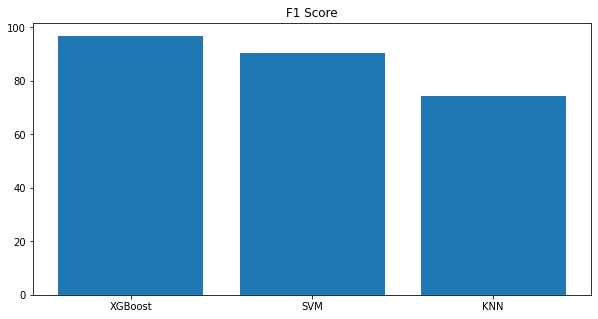

In [87]:
# Sort f1 results by value
f1_results = dict(sorted(f1_results.items(), key=lambda item: item[1], reverse=True))
print(f1_results)

# Plot f1 results
plt.figure(figsize=(10, 5))
plt.title('F1 Score')
plt.bar(f1_results.keys(), f1_results.values())
plt.show()

### Best models (Accuracy Score)

{'XGBoost': 96.7741935483871, 'SVM': 90.32258064516128, 'KNN': 74.19354838709677}


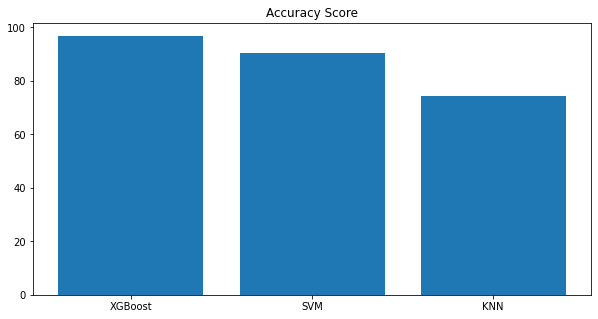

In [88]:
# Sort f1 results by value
acc_results = dict(sorted(acc_results.items(), key=lambda item: item[1], reverse=True))
print(acc_results)

# Plot f1 results
plt.figure(figsize=(10, 5))
plt.title('Accuracy Score')
plt.bar(acc_results.keys(), acc_results.values())
plt.show()

## Ensemble

In [89]:
def ensemble_model(X, y, models=[xgboost_model, knn_model, svm_model], pca_flag=[XGBOOST_PCA, KNN_PCA, SVM_PCA], smote_flag=[XGBOOST_SMOTE, KNN_SMOTE, SVM_SMOTE]):

    preds = []
    for ind in range(len(models)):
        print("Fitting model ", ind)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = models[ind]
        if pca_flag[ind]:
            pca = PCA(n_components=PCA_COMPONENTS)
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        if smote_flag[ind]:
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)

        print("F1 Score: ", f1_score(y_test, model.predict(X_test), average='weighted') * 100, '%')
        
        preds.append(model.predict(X_test))
    
    preds = np.array(preds)
    print(preds)

    preds = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=preds)

    print("F1 score: ", f1_score(y_test, preds, average='weighted') * 100, '%')

    return y_test, preds

In [90]:
ensemble_true, ensemble_pred = ensemble_model(X_norm, y_norm)

Fitting model  0
F1 Score:  96.835931470906 %
Fitting model  1
F1 Score:  74.42396313364054 %
Fitting model  2
F1 Score:  90.58531601226099 %
[[2 0 2 2 5 0 2 1 1 3 1 1 0 0 0 5 4 5 1 5 0 2 0 5 5 5 4 1 4 0 0]
 [2 0 2 2 4 0 2 1 1 3 1 1 1 0 1 4 4 5 1 4 0 2 1 5 4 5 4 1 4 0 0]
 [2 0 2 2 5 0 2 1 1 3 1 1 1 0 0 5 4 5 1 5 0 2 1 5 5 5 4 1 4 0 0]]
F1 score:  90.58531601226099 %


In [91]:
# Update f1_results with ensemble model
f1_results['Ensemble'] = f1_score(ensemble_true, ensemble_pred, average='weighted') * 100

{'XGBoost': 96.835931470906, 'SVM': 90.58531601226099, 'Ensemble': 90.58531601226099, 'KNN': 74.42396313364054}


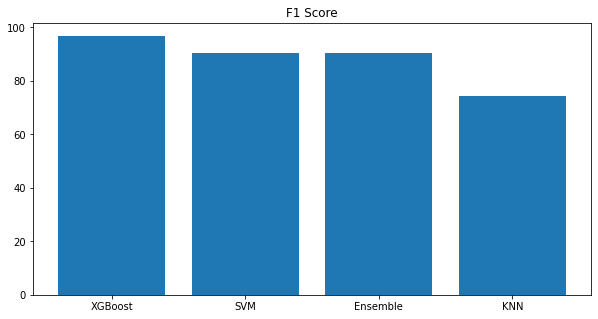

In [92]:
# Sort f1 results by value
f1_results = dict(sorted(f1_results.items(), key=lambda item: item[1], reverse=True))
print(f1_results)

# Plot f1 results
plt.figure(figsize=(10, 5))
plt.title('F1 Score')
plt.bar(f1_results.keys(), f1_results.values())
plt.show()